<h1>Quantifying Uncertainty <br> in Deep Learning Models</h1>

Michelle Laubinger and Johann Sonnenburg
                                              

Applied Predictive Analytics, Summer 2022

### Contents
1. [Introduction](#introduction)
2. [Literature Review](#litreview)
3. [Quantifying Uncertainty](#quantuncertainty)
    1. [Bayesian Inference](#bayesianstats)
    2. [Variational Inference](#varinference) 
    3. [Monte Carlo Dropout](#mcdropout)
4. [Data](#data)
5. [Methodology](#methods)
    1. [Variational Inference for Bayesian Neural Networks](#bnn)
    2. [Dropout Neural Network](#dropoutnet)
6. [Results](#results)
7. [Discussion](#discussion)
8. [Conclusion](#conclusion)
9. [Bibliography](#bibliography)

### 1. Introduction <a name="introduction"></a>

Standard deep learning models are typically viewed as deterministic functions where we obtain point estimators of the models' parameters and the predictions. Essentially, this means that we have to assume that a model is 100 percent certain about every prediction that it puts out. Thus, we are unable to determine any kind of uncertainty about these predictions. In many applications it is however necessary to be able to tell whether a model is certain about its output. If a model were to exhibit high uncertainty, this would imply that we should be careful when using the model's predictions as a base for decision-making. Furthermore, this would lead us to consider collecting more diverse data or changing the model altogether. 

In the context of credit risk analysis, we are concerned with evaluating the probability of default (PD) of a client to assess whether that client is creditworthy or not. However, the PD does not correspond to the (un)certainty that we have in a prediction, a mistake that is commonly made. Introducing a measure that expresses confidence in predictions would be beneficial, especially in a classification problem such as the one examined in this study. Consequently, corner cases could be identified, which could then be reevaluated by a more sophisticated model or a human expert.

Research about uncertainty quantification has gained significant traction in the last few years, with many applications in the fields of medical diagnosis, autonomous driving, and critical systems. It is also being applied to reinforcement and active learning with great success.
Credit risk classification is another problem setting for which the ability to quantify the uncertainty in deep learning models is of particularly high interest, since there exists a direct link between predictive accuracy and business performance. Being a highly regulated business sector, where transparency is required by law, uncertainty quantification could help mitigate the prevailing perception that deep learning models are black box methods and thus inappropriate in a credit risk setting.

Only recent research has allowed for the incorporation of Bayesian techniques into the standard deep learning toolbox. Bayesian methods have been known for some time, yet they have not been used to their full potential up until recently. Primarily, this was due to computational limitations, as Bayesian inference is a complex computational task that has traditionally been time- and resource-consuming, making it unattractive for practical purposes. While the heavily increased efficiency does come at a price, it has been shown to greatly increase transparency and predictive performance in a variety of problem settings.

In this application, we aim to provide a comprehensive summary of the relevant literature regarding uncertainty quantification in machine learning. Additionally, we implement two selected techniques used to quantify uncertainty in deep neural networks using financial data. 
 
This study is structured as follows: Chapter 2 comprises a detailed survey of the existing literature. The third chapter introduces the problem of quantifying uncertainty in deep learning and provides a theoretical background for the methods we later employ. Chapter 4 illustrates the way we prepare the data, Chapter 5 details the methodology we use in this study and the implementation of the models, and Chapter 6 reports the results. Finally, Chapter 7 provides a short discussion of our findings and Chapter 8 concludes our study with a brief summary.

### 2. Literature Review <a name="litreview"></a>

The quantification of uncertainty in deep learning has been the subject of a large body of research in recent years. Several studies provide an overview of the existing methods coupled with the required theoretical foundations. Gal (2016) lays out a comprehensive summary of existing techniques and gives an extensive theoretical introduction to what uncertainty is in the context of machine learning and to the mathematical theories behind the most commonly applied methods. Notably, he provides an intuition on the link between deep learning models and Gaussian processes and summarizes the historical literature related to Gaussian processes before moving to traditional techniques for performing variational inference (VI), which represent updates of these historical ideas. Surveying how inference was conventionally performed in Bayesian neural networks, Gal (2016) highlights shortcomings of these established techniques, such as the inability to scale to large data or to adapt to complex models. He emphasizes the lack of practicality of most of these techniques, rendering them unsuitable for most practical applications. Moving on to approximate variational techniques (Blundell et al., 2015, Graves, 2011, Kingma and Welling, 2013), he outlines how these laid the groundwork for modern implementations of Bayesian neural networks which overcome the before-mentioned shortcomings. In this light, he introduces his own work done in Gal and Ghahramani (2016a), Monte Carlo (MC) dropout, as a modern and practical alternative that is equivalent to performing approximate inference. Comparing variational inference, probabilistic backpropagation (Blundell et al., 2015), and MC dropout in terms of performance and data fit on several benchmarking problems, he shows the superior performance of dropout compared to other techniques. Furthermore, Gal (2016) introduces the variation ratio as a measure of uncertainty in classification problems which is applicable to MC dropout. Finally, he outlines the applications of uncertainty quantification in Bayesian convolutional neural networks and Bayesian recurrent neural networks and provides examples for several applications of these techniques, while illustrating their use in the form of experiments. Lastly, he supplies practical advice for using MC dropout and summarizes which factors influence the uncertainty quality in the implementation of neural networks.

In a systematic survey of the literature covering over 2500 papers from 2010 to mid-2020, Abdar et al. (2021) aim to review the most important papers on uncertainty quantification and its applications in the fields of, among others, computer vision, medical image analysis, and natural language processing. To this end, they additionally provide a theoretical introduction to the subject of uncertainty quantification, dealing with MC dropout, Markov Chain Monte Carlo, VI, Bayes by Backprop, and variational autoencoders. Similar to Gal (2016), they provide a background to measuring uncertainty in predictive modeling and discuss fundamental methods such as deep Gaussian processes. Furthermore, they summarize the literature on Bayesian reinforcement and active learning.

Similarly, Hüllermeier and Waegeman (2021) provide an introduction to uncertainty quantification in machine learning. In addition to reviewing common methods for handling uncertainty, they study comprehensively the sources of uncertainty in supervised learning. They specifically focus on how different methods can distinguish different forms of uncertainty. Finally, Hüllermeier and Waegeman (2021) point out the lack of awareness for model uncertainty in standard machine learning approaches and the resulting overconfidence in model outputs.

In this study, we will focus on two methods of performing Bayesian inference in detail. One is an approach implementing automatic variational inference via Automatic Differentiation Variational Inference (ADVI, as introduced by Kucukelbir et al., 2015), while the other is Monte Carlo dropout (Gal and Ghahramani, 2016a).

Deep learning models are closely connected to the concept of Gaussian processes. If we were to place a probability distribution over each weight within a neural network, a Gaussian process could be recovered in the limit of infinitely many weights (Neal, 1995). In the slightly more realistic setting of a finite number of weights, we can still obtain model uncertainty by placing probability distributions over these weights. We call such a model a Bayesian neural network (MacKay, 1992). Traditionally, these models and their newer derivatives (e.g., Kingma and Welling, 2013, or Blundell et al., 2015), are often difficult to work with and lack practicality, as highlighted by Gal (2016).

One of the key tasks in Bayesian inference is numerical integration. Due to the limited tractability of analytical solutions and their high computational efforts (in cases where they do happen to be tractable), approximate Bayesian inference has gained popularity over the years. Minka (2001) divided methods for approximate Bayesian inference into deterministic methods and nondeterministic methods. The latter randomly sample from the integrand to stochastically estimate the integral. Well known examples of this are Markov Chain Monte Carlo (MCMC) methods such as Metropolis sampling and Gibbs sampling (Wainwright and Jordan, 2008). Deterministic methods on the other hand attempt to find an approximation of the integrand by using densities whose integrals are known exactly. Variational methods fall into this category, which constitute a family of optimization-based problem formulations and their related solution techniques. The goal of variational inference is approximating a conditional density of latent variables given observed variables using optimization. To manage complexity, a family of densities is proposed over the latent variables that is flexible enough to entail a density as close as possible to the true posterior, but simple enough to enable efficient optimization (Blei et al., 2018). Here, the Kullback-Leibler divergence is commonly used as a similarity measure to evaluate the proximity of the approximate density and the true posterior. Specifically, VI comprises specifying a parameterized family of distributions that seems appropriate, computing the corresponding objective function, taking the derivatives, and running a gradient-based or coordinate-ascent optimization (Kucukelbir, 2017). Using Automatic Differentiation Variational Inference (ADVI), these computations can be automated, leaving the user with the task of specifying the model while ADVI takes care of generating the corresponding variational algorithm. This enables the use of common machine learning models such as generalized linear models, mixture models, Gaussian process models etc. 

Hinton et al. (2012) introduce dropout as a regularization technique specifically to prevent hidden units from developing complex co-adaptations on the training data set. Dropout can also be viewed as a highly efficient way of performing model averaging with neural networks. Predictions are performed at test time by using a “mean network” where all hidden units are used but the outgoing weights are scaled by the respective dropout probability. Hinton et al. (2012) show that dropout improves model performance on many benchmark tasks.

Elaborating on the work done by Hinton et al. (2012), Srivastava et al. (2014) perform an in-depth analysis of the application of dropout to various supervised learning problems. They find that training a network with dropout and predicting using the mean network “leads to [a] significantly lower generalization error on a wide variety of classification problems compared to training with other regularization methods” (Srivastava et al., 2014, p. 1931). However, they note that applying dropout results in an increase in training time compared to networks without dropout due to the parameter updates being very noisy. Additionally, they provide a practical guide to training dropout networks.

Gal and Ghahramani (2016a), following Srivastava et al. (2014), lay the groundwork for a new approach for performing approximate inference by establishing a connection between dropout and variational inference. They develop a novel theoretical framework for using dropout in deep neural networks called MC dropout and show that it is mathematically equivalent to approximate Bayesian inference in deep Gaussian processes. Previously, dropout was motivated by an evolutional theory on sexual reproduction (Srivastava et al., 2014). Hence, Gal and Ghahramani (2016a) are the first to provide a mathematical foundation for the technique. Crucially, they show that dropout can be used to model uncertainty in any neural network that applies this type of regularization in the required fashion. This new approach overcomes previous limitations of uncertainty modeling related to computational costs and test performance. Illustrating how model uncertainty can be modeled in dropout neural networks, they additionally study uncertainty quantification with dropout by examining various network architectures on regression and classification tasks such as MNIST. Gal and Ghahramani (2016a) confirm that using dropout can provide an improvement in data fit and performance compared to existing state-of-the-art methods such as variational inference or probabilistic backpropagation.

As we will use a credit risk data set to illustrate different ways of quantifying uncertainty in deep learning models, we provide a concise overview of the relevant literature. Tarashev (2009) emphasizes the importance of uncertainty quantification in a credit risk setting, by finding that ignoring parameter estimation noise leads to a severe understatement of the correct value-at-risk, which measures risk of loss for investments.

Employing several different prediction models to analyze over 110,000 observations on enterprise defaults from a European bank, Addo et al. (2018) find that deep learning models do not outperform tree-based classifiers. Among their prediction models are four different deep learning models, one of which makes use of dropout regularization. Addo et al. (2018) note that transparency is of great importance in the credit industry and that models are required to incorporate it to ensure that they work properly. This is relevant because predictive accuracy and returns are directly related in this industry, but also to avoid discrimination.

Similarly, Sirignano et al. (2018) utilize deep learning models to analyze US mortgage data comprising over 120 million observations. They note that deep learning models are especially appropriate for this type of financial modeling as they are able to uncover highly nonlinear influences of variables on the target and potential interaction effects among them. Notably, they employ a relatively large deep neural network and apply dropout regularization. 

Finally, Albanesi and Vamossy (2019) find a deep learning model to outperform standard credit scoring models for predicting consumer default. They point out the evident financial motivation for using better models and find their neural network to improve predictive accuracy while increasing transparency and accountability.

### 3. Quantifying Uncertainty <a name="quantuncertainty"></a>

In predictive modelling, uncertainty can be classified into two categories: aleatoric and epistemic uncertainty. 
Aleatoric uncertainty, which is sometimes also referred to as statistical uncertainty, describes the randomness of an experiment. More specifically, it characterizes the variability in the outcome of an experiment that is caused by random effects. Consequently, aleatoric uncertainty can be seen as a property of the underlying data distribution, making it irreducible due to the stochastic relationship between the covariates and the outcome. Aleatoric uncertainty also captures noise sources such as measurement noise - noise that cannot be explained away even if more data were available (although this uncertainty can be reduced through the use of higher precision sensors for example). 
 
In contrast, epistemic uncertainty occurs due to faulty or scarce knowledge which leads to models being incomplete, noisy, discordant, or multimodal. It essentially entails the amount of information about a hypothesis that would be gained through knowledge of the true outcome. It can be formulated as a probability distribution over the model parameters and expressed in terms of likelihood. For classification problems, a softmax likelihood can be used. Epistemic uncertainty reduces as the amount of observed data increases, hence it is also called “reducible uncertainty”. It can be thought of as a way to express confidence in the model structure. If we are able to quantify how certain the model is about its predictions and its parameters, we can use this information to compare different models and choose parameters that lead to more certain predictions.

Conclusively, predictive uncertainty can be formulated as

$$PU = EU + AU,$$

where $PU$ is the predictive uncertainty, $EU$ is the epistemic uncertainty, and $AU$ is the aleatoric uncertainty.
 
When using  neural networks for predictive tasks like binary classification, our model output expresses certainty by indicating the probability with which an outcome is likely to happen. Uncertainty quantification takes this one step further by expressing the certainty in that probability. Moreover, probabilistic modeling not only captures the uncertainty about the outcome, it is able to express (epistemic) uncertainty about each parameter of the model - the network weights in the context of neural networks.

### 3a. Bayesian Inference <a name="bayesianstats"></a>

Contrary to the frequentist approach to statistics, Bayesian models incorporate our belief or our uncertainty about the distribution of the unknown parameter before observing any data. This is called the prior distribution $p(\omega)$ over the unknown parameters, the weights $\omega$ in the case of a neural network. When we observe data, consisting of the feature matrix $\mathbf{X}$ and the target matrix $\mathbf{Y}$, we can update this prior belief to fit the data better using the observational model $p(\mathbf{Y}|\mathbf{X}, \omega)$, which coincides with the likelihood of the model. This updated probability distribution is proportional to the posterior distribution. We normalize the posterior by dividing it by the marginal distribution of the data which is also called the evidence. In practice, the evidence is always unknown (Gelman et al., 1995). Formally, we utilize Bayes' theorem to compute the posterior distribution $p(\omega|\mathbf{X},\mathbf{Y})$ as

$$p(\omega|\mathbf{X},\mathbf{Y}) = \frac{p(\mathbf{Y}|\mathbf{X}, \omega) p(\omega)}{p(\mathbf{Y}|\mathbf{X})}.$$

Thus, we "learn" the distribution of the unknown parameters by updating our prior knowledge with the observed data to obtain the posterior distribution.

We can then use this posterior predictive distribution to predict the output $y^*$ given a new input point $x^*$ as 

$$ p(y^*|x^*) = \int p(y^*|x^*, \omega)p(\omega|\mathbf{X},\mathbf{Y})d\omega,$$

which is called performing *inference* (Gal 2016).

Bayesian models typically require a carefully chosen and tuned prior distribution based on a priori knowledge. At times when we lack this knowledge, we would use an uninformative prior which does not convey any information (although it should be mentioned that no prior is truly uninformative). In this application, we consider an uninformative Gaussian prior defined through our chosen length-scale, which will be elaborated on later, as done in Gal and Ghahramani (2016a). While Gaussian priors are typically more suitable for regression problems, they can be applied to classification problems as well (Neal, 1998).

### 3b. Variational Inference <a name="varinference"></a>

At first glance, using a Bayesian approach to learning in neural network may seem counterintuitive, since specifying a prior for the neural network weights based on knowledge we have about their relationship appears complicated at best. However, MacKay (1992) shows that simply specifying a prior that models the weights as coming from a Gaussian proves sufficient. Still, even for small data sets and networks, obtaining the posterior often becomes intractable due to the nonlinear relationship between the network weights, as pointed out by Bishop (2006). Computationally heavy approximation techniques are required to yield results which makes using such traditional methods for larger data sets inefficient or even impossible. 
In modern Bayesian statistics, models' posterior distributions are increasingly difficult to compute and analytical solutions often become intractable. To overcome these problems, approximation techniques have been extensively studied and developed.
MCMC sampling methods have likely received the most attention, but their scalability to large data sets or complex models is lacking due to high computational efforts (Blei et al., 2018). In those instances, variational inference (VI) has proven to be an alternative approach that uses less computational power. Rather than sampling Markov chains, VI relies on optimization, more specifically on the minimization of the Kullback-Leibler (KL) divergence, which is a measure of similarity between two probability distributions. 
The goal of variational inference is to approximate a conditional density of latent variables given observed variables using optimization. To manage complexity, a family of densities is proposed over the latent variable, that is flexible enough to entail a density as close as possible to the true posterior, but simple enough to enable efficient optimization (Blei et al., 2018).
 
Hence, the goal is to estimate a function $y=f(x)$ that is likely to have generated the data. A distribution $p(f)$ is defined that reflects the likelihood of functions that are likely to generate the data according to prior beliefs. Next, a likelihood $p(\mathbf{Y}|f,\mathbf{X})$ is defined that captures the data-generating process of the observations, conditional on a specific function. A posterior distribution $p(f|\mathbf{Y},\mathbf{X})$ is then sought that represents the most likely functions given the observed data. This distribution can subsequently be used to predict outputs for new input points by integrating over all possible functions $f$.
In many cases, this integral needs to be approximated, which is done by conditioning the model on a finite set of random variables $\omega$. This implies the assumption that the model depends on these variables alone. Because the distribution $p(\omega|\mathbf{X}, \mathbf{Y})$ can mostly not be evaluated analytically, a variational distribution $q(\omega)$ is used to approximate the posterior distribution obtained from the original model. The Kullback-Leibler divergence is used as a measure of similarity between these two distributions as $\mbox{KL}(q(\omega)||p(\omega|\mathbf{X}, \mathbf{Y})$. Minimizing the Kullback-Leibler divergence (maximizing the similarity between the approximate and the true posterior) is the same as maximizing the log evidence lower bound with respect to the variational parameters defining $q(\omega)$. This computational procedure is known as variational inference.

### 3c. Monte Carlo Dropout <a name="mcdropout"></a>

#### From Stochastic Regularization Technique to Approximating Bayesian Neural Networks
Gal (2016) highlights several challenges that arise when implementing approximate inference techniques for practical applications. These include:
1. Scalability; the technique should scale well to large data,
2. Adaptability; the technique should easily adapt to complex models,
3. Deployability; the technique should not necessitate the change of existing model architectures or objectives,
4. Practicality; The technique should be easy for practitioners without expert knowledge to comprehend and apply.

Any technique that does not satisfy these requirements will, according to Gal (2016), simply not be used in industry applications.

The approach employed by Gal (2016) to model uncertainty makes use of a stochastic regularization technique (SRT) to model uncertainty.
In deep learning, regularization traditionally refers to a penalty term that is added to the loss function to impose an additional cost on the optimization function with the goal of preventing overfitting. 
In a broader, updated sense it is "any modification we make to a learning algorithm that is intended to reduce its test error but not its training error" (Goodfellow et al., 2016, Ch. 5). An example for such a modification that does not involve a penalty term is early stopping.
Stochastic regularization extends traditional regularization techniques by introducing randomness into a model through, e.g., stochastically varying the model architecture for each batch during training time.

SRTs include dropout (Hinton et al., 2012), multiplicative Gaussian noise (Srivastava et al., 2014), and dropConnect (Wan et al., 2013). Using SRTs it is possible to generate varying outputs by using the model during test time the same way it is used during training time: the model structure is stochastically varied, resulting in differing predictions. This allows for obtaining an approximative predictive distribution. We can then compute empirical estimates for the moments of this distribution, including the mean and the variance, which will allow us to quantify a model's uncertainty on a case-by-case basis. As SRTs are extremely widespread, the implication of this approach is that we will be able to model uncertainty in a straightforward way in any network architecture that makes use of SRTs.

Srivastava et al. (2014) formalized dropout as a computationally efficient alternative to the idea of using an ensemble of deep learning models to reduce overfitting. Because deep learning models are increasingly large and require a long time to train, combining the outputs from a high number of them is prohibitively expensive in terms of time and computational resources. The key idea of dropout is to randomly drop units along with their associated connections with a set probability for each batch during training time to prevent the units from overly co-adapting. At test time, a single network with scaled-down weights is used. Here, the outgoing weights from a node are multiplied by the dropout probability. Srivastava et al. (2014) showed that this method manages to reduce overfitting significantly while improving the model performance on a range of benchmark problems. Figure 1 depicts a neural network before and after applying dropout.

<!--- ![alt text](dropout_nn.png "Title")
<body>
    <div style="width:800px; margin:0 auto;" class="image" style="display:table;">
        <img src="dropout_nn.png" alt="" width="500"/>
        <div style="display:table-caption;
                    caption-side:bottom;horizontal-align:middle">Nitish Srivastava, Geoffrey Hinton, Alex Krizhevsky, Ilya Sutskever, and Ruslan Salakhutdinov.
    Dropout: A simple way to prevent neural networks from overfitting. JMLR,
    2014.</div>
    </div>
</body>
--->

<center><img src="dropout_nn.png" alt="" width="500"></center>
      <center>Figure 1: Applying Dropout<br> (Srivastava et al., 2014)</center>








<!--- continue with ghah2016 who build on srivastava --->
Extending the work of Srivastava et al. (2014), Gal and Ghahramani (2016a) show that a neural network of arbitrary depth with dropout applied before every weight layer is mathematically equivalent to an approximate deep Gaussian process. This result provides the theoretical foundation for being able to quantify uncertainty in networks that employ dropout. Notably, they highlight that this approximation can also be interpreted as approximate variational inference in Bayesian neural networks. Furthermore, they introduce MC dropout as a superior alternative to averaging the model weights as done by Srivastava et al. (2014). The main idea of MC dropout is that each random dropout configuration of the neural network asymptotically corresponds to a sample from the approximate parametric posterior distribution. Monte Carlo integration can then be used to infer properties about the distribution. The results of stochastic forward passes through the network are averaged to obtain a prediction, while the predictions themselves approximate the predictive distribution given an input.


<!--- actual implementation etc in methodology (including formulas for mean, variance, regularization term) --->

### 4. Data <a name="data"></a>

In this application, we are using a data set containing borrowers of mortgage loans from a US financial institution. This data set also includes a variable which states whether or not a borrower defaulted on their loan over a three-year horizon. This is the variable we will be trying to predict using our models. The data covers a time period from 2013 to 2016 and nearly 150,000 distinct loans.

In [2]:
import pandas as pd
import numpy as np
import preprocessing as pp

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data_train = pd.read_csv("data/data_train.csv")

After reading in the data, we first recode the values that indicate missing values following the data set description.

In [ ]:
data_train = pp.recodeMissing(data_train)

Next, we reduce the cardinality of the zipcode variable by applying Principal Component Analysis.

In [ ]:
data_train = pp.recodeZipcode(data_train)

Before continuing further, we will remove all redundant features as well as those that we deem to not contain a significant amount of additional information.

In [ ]:
data_train = pp.removeColumns(data_train)

Finally, we will recode all the dummy variables appropriately in line with the data set description.

In [ ]:
data_train = pp.recodeDummies(data_train)

Now we are ready to split the data into a training and a validation set.

In [ ]:
X = data_train.drop("TARGET", axis=1)
y = data_train.TARGET

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In both the training and the validation set, we dummy-encode the categorical features. Because we are using at least one neural network that employs weight decay, we will not remove a category from the recoded features. This is because the network would become biased in favor of the omitted category.

In [ ]:
X_train = pp.getDummies(X_train)
X_val = pp.getDummies(X_val)

Within both sets, we normalize the continuous features.

In [ ]:
X_train = pp.normalizeFeatures(X_train)
X_val = pp.normalizeFeatures(X_val)

Finally, we handle the missing values. For features with only very few missing values, we remove those observations. We identified these features to be the credit score ("fico"), the first-time homebuyer flag ("flag_fthb"), and the original combined loan-to-value ratio ("cltv"). As there are a few variables with a more significant number of missing values, we will impute these values using the k-Nearest Neighbors algorithm.

In [ ]:
X_train[["flag_fthb", "fico", "cltv"]].isna().sum()

flag_fthb    8
fico         8
cltv         1
dtype: int64

In [ ]:
y_train = y_train[~X_train["flag_fthb"].isna() & ~X_train["fico"].isna() & ~X_train["cltv"].isna()]

X_train = X_train.dropna(subset=["flag_fthb", "fico", "cltv"])

y_val = y_val[~X_val["flag_fthb"].isna() & ~X_val["fico"].isna() & ~X_val["cltv"].isna()]

X_val = X_val.dropna(subset=["flag_fthb", "fico", "cltv"])

We will fit the imputer on the training set only in order to avoid data leakage.

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns = X_train.columns)
X_val = pd.DataFrame(imputer.transform(X_val), columns = X_val.columns)

Lastly, we will compute the initial imbalance ratio of the training set. As we are dealing with a credit risk classification problem, it is natural that the negative class heavily outweighs the positive class, where positive means that a default on the loan occured. To improve the predictive performance, we will resample the training set using Synthetic Minority Over-sampling technique (SMOTE) to create more instances of the positive class before applying random under-sampling to prune the data.

In [ ]:
ir = y_train.value_counts()[0] / y_train.value_counts()[1]
print("Imbalance ratio: ", ir.round(2))

Imbalance ratio:  110.29


In [ ]:
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

cat_features = np.array([1, 10, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

smt = SMOTENC(categorical_features=cat_features, sampling_strategy=0.3, random_state=666)

rus = RandomUnderSampler(random_state=123,
                        sampling_strategy=0.3)

In [ ]:
from imblearn.pipeline import Pipeline

pipeline = Pipeline([('smt', smt), ('rus', rus)])

X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

In [ ]:
# save the data sets
X_resampled.to_csv("data/X_resampled.csv")
y_resampled.to_csv("data/y_resampled.csv")

X_val.to_csv("data/X_val.csv")
y_val.to_csv("data/y_val.csv")

Finally, we verify that the resampling process worked as expected by checking the imbalance ratio of the resampled training set.

In [ ]:
ir = len(y_resampled)/y_resampled.sum()
ir = y_resampled.value_counts()[0] / y_resampled.value_counts()[1]
print("Imbalance ratio after applying SMOTE and random under-sampling: ", ir.round(2))

Imbalance ratio after applying SMOTE and random under-sampling:  3.33


### 5. Methodology <a name="methods"></a>

We will be using two different approaches to quantify uncertainty in neural networks, which we implement in this chapter, namely variational inference and MC dropout. The goal of this section is to compare how these models differ in measuring uncertainty. To facilitate this comparison, we will be using the same network architecture across both models. We will first provide an additional theoretical background concerning the implementation of the two models as well as of how to use them to measure uncertainty in practice before describing their respective actual implementation used in our application.

### 5a. Variational Inference for Bayesian Neural Networks <a name="bnn"></a>

Traditional learning methods minimize some objective function and obtain point estimates of the optimal parameters. In contrast, Bayesian learning methods output a distribution over probable parameters, indicating their likelihood and thus take into account uncertainty (MacKay 1995).\
As mentioned in Section 3a, the posterior distribution $p(\omega|\mathbf{X},\mathbf{Y})$ is calculated by normalizing the joint distribution over the observed and latent variables, $p(\mathbf{Y}|\mathbf{X}, \omega) p(\omega)$, by the evidence $p(\mathbf{Y}|\mathbf{X})$,
which is unknown. Based on Gal and Ghahramani (2016b), we can estimate the evidence as

$$p(\mathbf{Y}|\mathbf{X})=∫p(\mathbf{Y}|\mathbf{X},\omega)p(\omega)d\omega.$$

However, this integral is intractable. 
As a workaround, variational methods find a variational distribution $q^*$ that is part of a predefined family of distributions $Q$ and best fits the true posterior distribution $p(\omega|\mathbf{X},\mathbf{Y})$. In VI, performing approximate posterior inference thus becomes an optimization problem (Blei et al., 2018). The goal is to find a distribution that comes as close to the true posterior as possible, where we measure the distance using the Kullback-Leibler divergence. Based on Gal (2016), the KL divergence is generally computed as

$$\mbox{KL}(q(\omega)||p(\omega|\mathbf{X})) =∫q(\omega)\log\frac{q(\omega)}{p(\omega|\mathbf{X})}d\omega = -\int q(\omega)\log\frac{p(\omega|\mathbf{X})}{q(\omega)}d\omega.$$

Here, we would require the true posterior. Instead, we can maximize the evidence lower bound (ELBO), which, up to an added constant, is equivalent to minimizing the KL divergence (Kucukelbir, 2017) and can be written as

$$\mathbb{E}_q[\log p(\mathbf{X}|\omega)]-\mbox{KL}(q(\omega)||p(\omega)).$$

Maximizing the first term means selecting those models from the variational family $q \in Q$ that better predict the data. This also implies that the second term, the negative KL divergence between the variational model and the prior over the latent variables, is pushed towards zero, inferring that the distributions are as similar to each other as possible. 
 
Evidently, a crucial step in performing variational inference is specifying the family of distributions from which that member is chosen which best approximates the true posterior. Then, the corresponding objective function needs to be formulated before computing the derivatives and running a gradient-based or coordinate-ascent optimization (Kucukelbir et al., 2016). 
Using Automatic Differentiation Variational Inference, these computations can be automated. As model output, we not only obtain predictions and point estimates of our weights, but we additionally receive probability distributions for each of the network weights in the model. 
Following Kucukelbir et al. (2016), the steps of ADVI are as follows:
1. ADVI transforms the model into one with unconstrained real-valued latent variables
2. ADVI defines the corresponding variational problem on the transformed variables. All latent variables are defined on the same space, so only one single variational family for all models is needed
3. ADVI reparameterizes the gradient in terms of a standard Gaussian, thus another transformation is performed, this time within the variational family which enables efficient computation of Monte Carlo approximations, because we only need to sample from a standard Gaussian
4. ADVI uses noisy gradients to optimize the variational distribution

Consequently, due to the Bayesian nature of the method, uncertainty quantification is directly incorporated into the model and expressed in terms of probability distributions over all unknown parameters. As Neal (1995) points out, the combination of this likelihood function across all parameter values and the predefined prior distribution yields the posterior distribution which conclusively incorporates both the initial belief conveyed by the prior and the observed information from the likelihood. We can learn from this final probability distribution using standard methods from probability theory.

#### Implementing the Model

Due to computational limitations, we implement the model making use of ADVI in a cloud-based environment. It can be accessed [here](https://colab.research.google.com/github/jsonnenburg/apa_topic5/blob/main/VImodel.ipynb).
<!---
[![Implementation of ADVI in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://www.google.com/) 
--->

Using this approach, we try to maximize the ELBO which corresponds to minimizing the KL divergence. 
The plot below shows the negative ELBO track for the 30,000 iterations. We observe that with increasing iterations, the loss converges, indicating that we are able to find an estimated (variational) posterior that is sufficiently similar to the true posterior and enables approximate inference.

<center><img src="images/elbo_curve.png" alt="" width="1000"></center>
      <center>Figure 2: Negative ELBO track of the Variational Inference Model</center>

### 5b. Dropout Neural Network <a name="dropoutnet"></a>
As explained in Section 3c, Gal and Ghahramani (2016a) show that dropout approximates variational inference in Bayesian neural networks. They find that the dropout objective effectively "minimizes the Kullback-Leibler divergence between an approximate distribution and the posterior of a deep Gaussian process" (Gal and Ghahramani, 2016a, p.3). As opposed to the standard way of applying dropout only during training when using it simply as a regularization technique, Gal and Ghahramani (2016a) apply it also at test time to obtain a distributional prediction when performing a specified number of stochastic forward passes through the neural network. We can then compute the empirical estimates of the moments of this approximate predictive distribution. 

<!--- first and second moment --->

If we consider $x^*$ a vector of a single new input and $\hat{y}^*$ the corresponding vector of outputs of the neural network with length $T$, the number of stochastic forward passes through the network, then we can compute an unbiased estimator of the first moment of the predictive distribution using MC integration as

$$\mathbb{E}_{q(y^*|x^*})(y^*) \approx \frac{1}{T}\sum_{t=1}^{T}\hat{y}^*(x^*,W^t_1,...,W^t_L),$$

with $\{W^t_1,...,W^t_L\}^T_{t=1}$ vector sets of realizations from the Bernoulli distribution.

Using
$$\mathbb{E}_{q(y^*|x^*)}\big((y^*)^T(y^*)\big)\approx \tau^{-1}I_D + \frac{1}{T}\sum_{t=1}^{T}\hat{y}^*(x^*,W^t_1,...,W^t_L)^T\hat{y}^*(x^*,W^t_1,...,W^t_L),$$

we can compute the second moment of the predictive distribution similarly as

$$\mbox{Var}_{q(y^*|x^*)(y^*)} \approx \mathbb{E}_{q(y^*|x^*)}\big((y^*)^T(y^*)\big) - \mathbb{E}_{q(y^*|x^*)}(y^*)^T\mathbb{E}_{q(y^*|x^*)}(y^*),$$

which is equal to the sample variance computed over the number of stochastic forward passes plus the inverse of the model precision $\tau$. The first two moments of the approximate predictive distribution will act as an indicator of model uncertainty. Thus, we are able to obtain some quantification of this type of uncertainty by performing stochastic forward passes through the model and collecting the model output for each pass, which are then the approximate predictive distribution. In classification tasks, we can make use of additional measures of uncertainty such as the variation ratio (VR) of the model predictions that is superior to the variance or standard deviation in this setting. For each input, we collect the set of $T$ outputs and find the mode of this output distribution sample as $c^* = \arg \max \sum_{t}\mathbb{1}[y^t = c]$ together with the number of times it is contained in the sample, $f_x = \sum_{t}\mathbb{1}[y^t = c^*]$. Then,

$$\mbox{VR}[x]:= 1 - \frac{f_x}{T}.$$

Gal and Ghahramani (2016a) introduce the VR as a measure of how scattered the distribution of outputs is around the mode. In a binary classification task, the VR attains a maximum of 0.5 in the case of the two classes being contained in the sample from the approximate predictive distribution the same number of times, and a minimum of 0 if the sample contains only a single class.

Importantly, measures such as the variance for regression and the entropy or VR for classification problems do not capture a model's confidence in its output but the total uncertainty in the prediction.
This uncertainty contains both the variance of the observation error, the aleatoric uncertainty, and the variance due to parameter uncertainty, the epistemic uncertainty (Hüllermeier and Waegeman, 2021).

<!--- 
$$Var_{q(y^*|x^*)(y^*)} \approx \mathbb{E}_{q(y^*|x^*)}\big((y^*)^T(y^*)\big) - \mathbb{E}_{q(y^*|x^*)}(y^*)^T\mathbb{E}_{q(y^*|x^*)}(y^*), \mbox{ with}$$

$$\mathbb{E}_{q(y^*|x^*)}\big((y^*)^T(y^*)\big)\approx \tau^{-1}I_D + \frac{1}{T}\sum_{t=1}^{T}\hat{y}^*(x^*,W^t_1,...,W^t_L)^T\hat{y}^*(x^*,W^t_1,...,W^t_L)$$
--->

The model precision mentioned above can be calculated as

$$\tau = \frac{l^2(1-p)}{2N\lambda},$$

where $l$ is the prior length-scale, a value that captures our belief about the model function's frequency, $1-p$ is the dropout rate, $N$ is the number of observations, and $\lambda$ is the weight decay.

We can rewrite this term to

$$\lambda = \frac{l^2(1-p)}{2N\tau},$$

such that we can later determine the optimal weight decay by optimizing over $p$ and $\tau$ while holding $l$ constant, as done in Gal and Ghahramani (2016a). 

A short prior length-scale $l$ will lead to more erratic functions with higher frequencies through input weights of high magnitude. A long prior length-scale will accordingly result in smoother functions and lower magnitude input weights. The combination of a short length-scale with high model precision will lead to a small weight decay, which encourages the model to fit the data well but leads to potential generalization difficulties. A large weight decay follows from pairing a long length-scale with low precision, facilitating the generalization. The trade-off between prior length-scale and model precision results in different values for the weight decay $\lambda$. This term represents choosing a prior distribution in the given setting, as explained in Gal and Ghahramani (2016a).

<!--- log likelihood --->
Gal and Ghahramani (2016a) calculate the predictive log-likelihood (LL) by MC integration. The LL will be used to optimize the model parameters $\tau$ and $p$ via grid-search as it is an indicator of how well the model fits the data. In addition, the LL can also be used to determine the quality of uncertainty. We compute the LL as

$$\log p(y^*|x^*, X, Y) \approx \mbox{logsumexp}\Big(-\frac{1}{2}\tau||y-\hat{y}_t||^2\Big) - \log T - \frac{1}{2}\log2\pi-\frac{1}{2}\log\tau^{-1}.$$

The last term results in a large penalty if the observation noise is large (i.e. the model precision is low). High model precision but poor mean estimates will result in a large penalty from the first term because the distance between the true and the predicted values gets amplified by $\tau$.  

As described in Gal (2016), we learn both the aleatoric noise and capture the epistemic uncertainty by grid-searching over the dropout probability and the model precision, respectively. 

#### Implementing the Model
In the implementation of the neural network, we will add an $L_2$ regularization term to the hidden layers. As mentioned previously, this corresponds to choosing a prior distribution and is a key component of Bayesian modelling. This prior does not convey concrete information as we have no initial beliefs about the weight distribution.

We will additionally add dropout regularization before every weight layer, as specified in Gal and Ghahramani (2016a). Crucially, we will apply dropout at both training and test time as opposed to just during training as is commonly done when using it as a regularization technique. This will allow us to simulate drawing samples from the approximate posterior predictive distribution $q_\theta(y|x)$.

In [ ]:
from scipy.special import logsumexp
import numpy as np
from scipy import stats

from keras.regularizers import l2
from keras import Input
from keras.layers import Dropout
from keras.layers import Dense
from keras import Model
from tensorflow import keras

import time

Adapting [the code](https://github.com/yaringal/DropoutUncertaintyExps/blob/master/net/net.py) provided by Gal and Gharamani (2016), we first define a class used to initialize the neural network, perform the stochastic forward passes to obtain a distributional prediction as well as to calculate the uncertainty measures, comprising an additional function with which we will calculate the predictive log-likelihood.

In [ ]:
class net:

    def __init__(self, X_train, y_train, X_val, y_val, n_hidden, n_epochs = 30, 
                 tau = 1.0, dropout = 0.05):

        """
            Constructor for the class implementing a Bayesian neural network
            trained with the probabilistic back propagation method.

            @param X_train      Matrix with the features for the training data.
            @param y_train      Vector with the target variables for the
                                training data.
            @param X_val        Matrix with the features for the validation data.
            @param y_val        Vector with the target variables for the 
                                validation data.
            @param n_hidden     Vector with the number of neurons for each
                                hidden layer, e.g., [10, 10] for two layers
                                with 10 neurons each.
            @param n_epochs     Numer of epochs for which to train the
                                network.
            @param tau          Tau value used for regularization.
            @param dropout      Dropout rate for all dropout layers in the
                                network.
        """

        X_train = np.array(X_train, ndmin = 2)
        y_train = np.array(y_train, ndmin = 2)
        
        # network params
        N = X_train.shape[0]
        batch_size = 128
        lengthscale = 1e-2
        reg = lengthscale**2 * (1 - dropout) / (2. * N * tau) 
        
        # network construction
        inputs = Input(shape=(X_train.shape[1],))
        inter = Dropout(dropout)(inputs, training=True)
        inter = Dense(n_hidden[0], activation='relu', kernel_initializer=keras.initializers.he_normal(seed=123), kernel_regularizer=l2(reg))(inter)
        for i in range(len(n_hidden) - 1):
            inter = Dropout(dropout)(inter, training=True)
            inter = Dense(n_hidden[i+1], activation='relu', kernel_initializer=keras.initializers.he_normal(seed=123), kernel_regularizer=l2(reg))(inter)
        inter = Dropout(dropout)(inter, training=True)
        outputs = Dense(y_train.shape[1], activation='sigmoid', kernel_initializer=keras.initializers.he_normal(seed=123), kernel_regularizer=l2(reg))(inter)
        model = Model(inputs, outputs)

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

        start_time = time.time()
        
        model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_val, y_val), verbose=0)
        
        # meta info params
        self.running_time = time.time() - start_time
        self.model = model
        self.tau = tau
        self.VR = None
        self.Yt_hat = None
        self.test_time = None

    def predict(self, X_test, T = 100):

        """
            Function for making predictions with the Bayesian neural network.

            @param X_test   The matrix of features for the test data.
            @param y_test   The matrix of labels for the test data.
            @param T        The number of Monte Carlo trials.
            
            @return MC_pred The predictive mean for the test target variables.
            @return 
            standard_pred   An array of predictions for the test target, 
                            computed from a single forward pass.
        """

        model = self.model
        
        # obtain single prediction
        standard_pred = model.predict(X_test, batch_size=500, verbose=0)
        
        self.T = T
        
        # obtain MC predictions
        start_time = time.time()
        preds = [model(X_test, training=True) for _ in range(T)]
        end_time = time.time()
        Yt_hat = np.hstack(preds)

        # calculate mean
        MC_pred = np.mean(Yt_hat, 1)
        
        # calculate variation ratio
        MC_mode = stats.mode(Yt_hat.round(), 1)[0] # c*
        fx = np.array([np.count_nonzero(Yt_hat.round()[i] == MC_mode[i]) for i in range(MC_mode.shape[0])]) # f_x
        VR = np.subtract(np.ones(fx.shape[0]), np.divide(fx, T))
        
        # save meta params
        self.VR = VR
        self.Yt_hat = Yt_hat
        self.test_time = end_time - start_time
        
        return  MC_pred, standard_pred
    
    def logLik(self, y_test):
        
        """
            Function for computing the predictive log-likelihood.
            
            @param y_test    The matrix of labels for the test data.
            
            @return test_ll  The predictive log-likelihood.
        """
        
        y_test = np.array(y_test, ndmin = 2)
        
        ll = (logsumexp(-0.5 * self.tau * (y_test[None] - self.Yt_hat)**2., 0) - np.log(self.T) 
            - 0.5*np.log(2*np.pi) + 0.5*np.log(self.tau))
        
        test_ll = np.mean(ll)
        
        return test_ll

#### Grid-Searching the Optimal Parameters

As done similarly in Gal and Gharamani (2016), we will perform grid-search over the LL to find the optimal values for the model precision $\tau$ and the dropout probability. Here, larger values for the LL signify a better fit to the data. Gal (2016) point out several considerations for choosing $\tau$ and the dropout rate in practice. Notably, larger models require a higher dropout probability, typically close to 0.5. For a fixed model size, smaller dropout probabilities will result in decreasing predictive uncertainty. If both the model precision and the amount of data are large, the model will be prone to overfitting. This results from giving the expected LL a higher weight than the prior KL divergence (Gal 2016). The length-scale $l$ will be constant so that the optimal weight decay $\lambda^*$ will depend only on two parameters.

<!---
- considerations for tau in practice (following gal2016):
    - larger models require larger dropout prob. (large models: close to 0.5)
    - for fixed model size, smaller dropout probabilities result in decreasing predictive uncertainty
    - large tau (high model precision) and large N (large amount of data) give expected LL a higher weight than the prior KL, makes model prone to overfitting
    - long prior length-scale results in heavily regularized models that are prone to underfitting
--->

In [ ]:
y_resampled = y_resampled.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)

Our neural network will be quite small, with only two hidden layers and a limited number of units in each layer, as we use it only for illustrative purposes. Following Gal (2016), we should opt for a smaller dropout probability given just the size of our network. However, the amount of data we will use for training the network is quite large. Hence, we will start the range of possible dropout rates used in the grid-search at a relatively high value. This will prevent the model from overfitting.

In [ ]:
# list of values for hyperparameters
dropout_rates = list([0.15, 0.2, 0.25])
tau_values = list([1.0, 1.5, 2.0, 2.5, 3.0, 3.5])

# perform grid-search to select the best hyperparameters based on the highest log-likelihood value
best_network = None
best_ll = -float('inf')
best_tau = 0
best_dropout = 0

for dropout_rate in dropout_rates:
    for tau in tau_values:
        print ('=== Grid-search step: tau at ' + str(tau) + ' and dropout rate at ' + str(dropout_rate) + '.')
        network = net(X_resampled, y_resampled, X_val, y_val, n_hidden = [64, 32],
                      n_epochs = 15, tau = tau, dropout = dropout_rate)

        _, _ = network.predict(X_val)
        
        # compute test log-likelihood on the validation set
        ll = network.logLik(y_val) 
        if (ll > best_ll): 
            best_ll = ll
            best_network = network
            best_tau = tau
            best_dropout = dropout_rate
            print ('Best log-likelihood changed to: ' + str(best_ll.round(4)))
            print ('Best tau changed to: ' + str(best_tau))
            print ('Best dropout rate changed to: ' + str(best_dropout))

# store best results
best_network = net(X_resampled, y_resampled, X_val, y_val, n_hidden = [64, 32],
                n_epochs = 20, tau = best_tau, dropout = best_dropout)

=== Grid-search step: tau at 1.0 and dropout rate at 0.15.
Best log-likelihood changed to: -5.5563
Best tau changed to: 1.0
Best dropout rate changed to: 0.15
=== Grid-search step: tau at 1.5 and dropout rate at 0.15.
Best log-likelihood changed to: -5.3722
Best tau changed to: 1.5
Best dropout rate changed to: 0.15
=== Grid-search step: tau at 2.0 and dropout rate at 0.15.
Best log-likelihood changed to: -5.2436
Best tau changed to: 2.0
Best dropout rate changed to: 0.15
=== Grid-search step: tau at 2.5 and dropout rate at 0.15.
Best log-likelihood changed to: -5.1473
Best tau changed to: 2.5
Best dropout rate changed to: 0.15
=== Grid-search step: tau at 3.0 and dropout rate at 0.15.
Best log-likelihood changed to: -5.0776
Best tau changed to: 3.0
Best dropout rate changed to: 0.15
=== Grid-search step: tau at 3.5 and dropout rate at 0.15.
Best log-likelihood changed to: -5.0056
Best tau changed to: 3.5
Best dropout rate changed to: 0.15
=== Grid-search step: tau at 1.0 and dropout r

### 6. Results <a name="results"></a>
In this chapter, we will first evaluate both models' performance on the validation set before exploring how the two models differ in their predictive uncertainty. Furthermore, we will illustrate the options each approach gives us to visualize and quantify the model uncertainty.

#### ADVI Network

To evaluate the general predictive performance of the model, we perform a posterior predictive check by sampling from the estimated posterior. Essentially, we generate data from our model and analyze how much that data deviates from the true posterior distribution. We then perform predictions for each observation in the validation set and assess the model's performance. 

In [ ]:
# for illustration - do not run
with neural_network:
    inference = inference
    train_trace = pm.sample_approx(approx, draws=100000, include_transformed=True)
    pm.set_data(new_data={"ann_input": X_val, "ann_output": y_val})
    ppc = pm.sample_posterior_predictive(train_trace, samples=50000, progressbar=True)
    VI_pred = ppc["out"].mean(axis=0)

We will first assess the general predictive performance of the model using a range of appropriate standard metrics. These include the AUC, as well as precision, recall, and the F1-score.

In [3]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

# import the saved predictions
VI_pred_class = pd.read_csv("data/classes.csv").astype(int)
y_val = pd.read_csv('data/y_val.csv')

tn, fp, fn, tp = confusion_matrix(y_val['TARGET'], VI_pred_class['0']).ravel()

recall = tp / (tp+fn)
prec = tn / (tn+fp)
f1 = 2*(prec*recall)/(prec+recall)

print("Precision: ", prec.round(3), "\nRecall:   ", recall.round(3), "\nF1-Score:  ", f1.round(3))

Precision:  0.891 
Recall:    0.161 
F1-Score:   0.272


With a BNN, we are also able to evaluate the standard deviation of the estimated posterior of the network weights to get an idea of the uncertainty within the network by examining their distribution, as depicted in Figure 3.

<center><img src="images/advi_weights.jpg" alt="" width="350"></center>
      <center>Figure 3: Approximate Posterior Predictive Distribution of the Network Weights</center>

Lastly, we can also look at the posterior densities in more detail. Specifically, we can plot the highest density interval (HDI) for each of the network weights, as done in Figure 4.
Based on Lu et al. (2012), a credible interval for a variable $X$ can be defined as $Prob (l\leq X\leq u)=1-\alpha$, where $l$ and $u$ are the lower and upper interval limits, $\alpha$ is the significance level and $1-\alpha$ is the confidence level. 
From a Bayesian viewpoint, the prediction is a random variable and a 94% credible interval is expected to include 94% of the probability distribution function of the prediction. In the case of the HDI, a 94% HDI includes all values of $x$ for which the density is as big as some value $W$, such that the integral over all those $x$-values is 94\%. Thus, the wider the distribution, the more uncertain we are about the true value of the parameter. 

<center><img src="images/HDI.png" alt="" width="900"></center>
      <center>Figure 4: Highest Density Intervals for Some Network Weights</center>

#### Dropout Neural Network

In [ ]:
MC_pred, standard_pred = best_network.predict(X_val, T=1000)

We evaluate the model utilizing the same metrics as used previously.

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, MC_pred)

roc_auc = auc(fpr, tpr)

print(f"AUC of best network: {roc_auc:.3f}")

AUC of best network: 0.731


In [ ]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_val, MC_pred.round()).ravel()

In [ ]:
recall = tp / (tp+fn)
prec = tn / (tn+fp)
f1 = 2*(prec*recall)/(prec+recall)

print("Precision: ", prec.round(3), "\nRecall:   ", recall.round(3), "\nF1-Score:  ", f1.round(3))

Precision:  0.936 
Recall:    0.208 
F1-Score:   0.34


To provide an idea of what the approximate posterior predictive distribution looks like for individual inputs, we visualize the output distribution together with the MC mean prediction and the prediction of a standard network that applies dropout only at training time for three randomly picked observations. The posterior probability distribution reflects the epistemic uncertainty in a Bayesian setting. The less peaked this distribution is, the less informed the learner is and the higher its epistemic uncertainty (Hüllermeier and Waegeman, 2021). We also depict the distribution of the variation ratio across all outputs. 

Generally, we expect inputs near the training data to have a smaller epistemic uncertainty component, while inputs far away from the training data will result in higher epistemic uncertainty. Similarly, some parts of the input space might have higher aleatoric uncertainty associated with them than others. These inputs will produce a larger measurement error.

In [ ]:
import random

random.seed(99)

idx = random.sample(range(len(X_val)), 3)

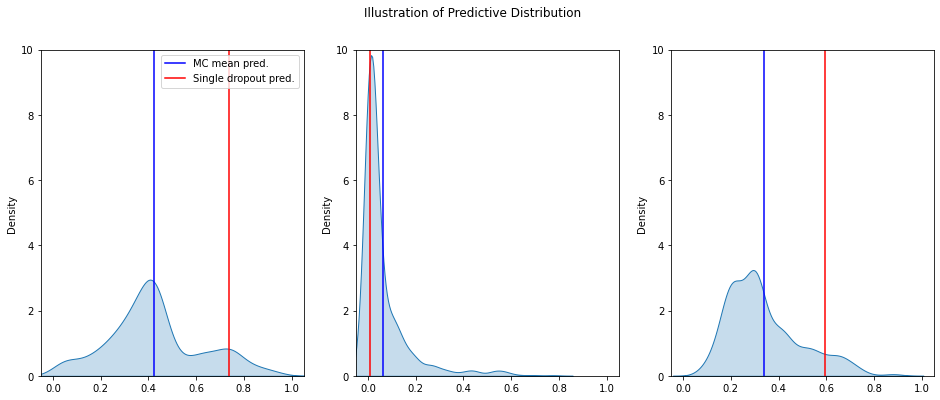

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))

plt.subplot(131)
sns.kdeplot(best_network.Yt_hat[idx[0]], shade=True)
plt.axvline(MC_pred[idx[0]], color="blue", label = "MC mean pred.")
plt.axvline(standard_pred[idx[0]], color='red', label = "Single dropout pred.")
plt.legend()
plt.xlim(-0.05, 1.05)
plt.ylim(0, 10)

plt.subplot(132)
sns.kdeplot(best_network.Yt_hat[idx[1]], shade=True)
plt.axvline(MC_pred[idx[1]], color="blue", label = "mc pred")
plt.axvline(standard_pred[idx[1]], color='red', label = "single pred.")
plt.xlim(-0.05, 1.05)
plt.ylim(0, 10)

plt.subplot(133)
sns.kdeplot(best_network.Yt_hat[idx[2]], shade=True)
plt.axvline(MC_pred[idx[2]], color="blue", label = "mc pred")
plt.axvline(standard_pred[idx[2]], color='red', label = "single pred.")
plt.xlim(-0.05, 1.05)
plt.ylim(0, 10)

plt.suptitle("Illustration of Predictive Distribution");

The figures above illustrate how well MC dropout is able to capture the multimodality of the posterior predictive distribution. We tend to observe a distribution with a strong spike for predictions about which the model is rather certain, while the distribution is flatter for instances about which the model is more uncertain.

Next, we will examine the measure of predictive uncertainty, the variation ratio, in more detail.

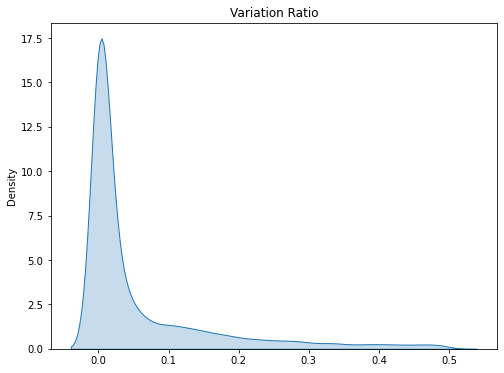

In [ ]:
plt.figure(figsize=(8,6))

sns.kdeplot(best_network.VR, shade=True)
plt.title("Variation Ratio");

While our model seems to be relatively certain about most predictions that it puts out, there appears to be a rather significant number of inputs for which this is not the case. We should be careful for observations where the VR is high, as we are not able to trust the model to be right here.

Additionally, we will visualize the predictive distribution for the two cases where the VR attains the lowest and highest value, respectively. This illustrates instances of high predictive certainty and high predictive uncertainty.

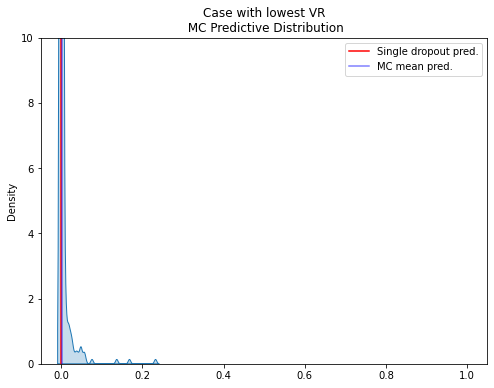

In [ ]:
plt.figure(figsize=(8,6))

lowest_vr = np.argmin(best_network.VR)

sns.kdeplot(best_network.Yt_hat[lowest_vr], shade=True)
plt.axvline(standard_pred[lowest_vr], color='red', label = "Single dropout pred.")
plt.axvline(MC_pred[lowest_vr], color="blue", label = "MC mean pred.", alpha=0.5)
plt.legend()
plt.xlim(-0.05, 1.05)
plt.ylim(0, 10)
plt.title('Case with lowest VR\n MC Predictive Distribution')
plt.show()

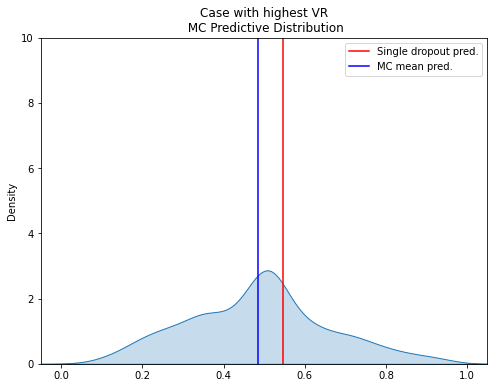

In [ ]:
plt.figure(figsize=(8,6))

highest_vr = np.argmax(best_network.VR)

# notice multimodal distribution
sns.kdeplot(best_network.Yt_hat[highest_vr], shade=True)
plt.axvline(standard_pred[highest_vr], color='red', label = "Single dropout pred.")
plt.axvline(MC_pred[highest_vr], color="blue", label = "MC mean pred.")
plt.legend()
plt.xlim(-0.05, 1.05)
plt.ylim(0, 10)
plt.title('Case with highest VR\n MC Predictive Distribution')
plt.show()

Finally, we quickly examine the overall trend of how the mean prediction we obtain via MC integration differs from the prediction of a standard network.

In [ ]:
# what is the mean deviation of the standard NN's prediction from the MC mean?
deviation = np.subtract(MC_pred.reshape(-1, 1), standard_pred)

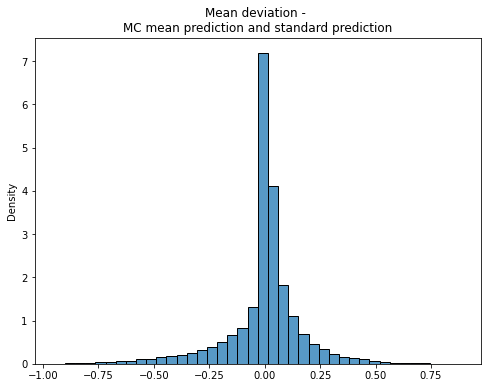

In [ ]:
plt.figure(figsize=(8,6))

sns.histplot(deviation.ravel(), bins = 40, stat = 'density')
plt.title('Mean deviation - \nMC mean prediction and standard prediction');

While they tend to be quite similar on average, there is a quite noticeable spread and the magnitude of the deviation is high for a few instances. This was to be expected as we essentially perform model averaging in MC dropout, which tends to improve our mean predictions and makes them more robust.

#### Head-to-head comparison

Lastly, we compare the training and test times across the network incorporating variational inference and the network for MC dropout. Additionally, we contrast the test time of the dropout network and a standard neural network.

Here, we expect the network incorporating MC dropout to have a training time that is equivalent to that of a normal neural network and drastically shorter than the model trained with ADVI.
The dropout neural network should have a test time that is roughly equivalent to that of a standard neural network, scaled by the number of stochastic forward passes, which we set to 1,000.

In [ ]:
# evaluate test time, compare to standard NN / VI NN

# standard NN with dropout
start = time.time()
best_network.model.predict(X_val, batch_size=500, verbose=0)
test_time1 = time.time() - start

# MC dropout
start = time.time()
best_network.predict(X_val, 1000) # 1000 forward passes
test_time2 = time.time() - start

In [ ]:
# training and test times across models

print(f"ADVI neural network - training time: 2h18min8s.")
print(f"Dropout neural network - training time: {best_network.running_time:.3f}s.")
print("-------------------------------------------------")
print(f"Standard neural network - test time: {test_time1:.3f}s.")
print(f"Dropout neural network - test time: {test_time2:.3f}s.")

ADVI neural network - training time: 2h18min8s.
Dropout neural network - training time: 220.238s.
-------------------------------------------------
Standard neural network - test time: 5.571s.
Dropout neural network - test time: 1075.438s.


Examining the results, we are able to confirm our initial beliefs with regard to the training and test times of the different networks. Notably, there exists a stark contrast between the training times of the network using ADVI and that using dropout. Furthermore, the test time of MC dropout is drastically higher than that of the standard network, as we would expect.

### 7. Discussion <a name="discussion"></a>

The goal of this study was to illustrate two practical approaches for performing uncertainty quantification in deep learning models.
Gal (2016) claimed that "over-parametrized" models result in better uncertainty estimates than smaller models. This is due to models with a large number of parameters being able to capture a larger class of possible functions. Thus, they are able to fit the data better, which consequently results in larger uncertainty estimates further away from the data. Although the models we presented in this work are rather shallow with a relatively small number of parameters and would usually not be called "deep" neural networks, the insights we derived are directly applicable to network architectures with more hidden layers.

The two methods we use allow us to obtain different views on the uncertainty for a given network: With variational inference (in the form of ADVI), we are able to model the uncertainty about the network weights and can thus quantify the inner workings of a networks; while with MC dropout, we cannot visualize or in effect quantify what happens within the network, but we are able to obtain visualizable posterior distributions for individual inputs, for which we subsequently are able to easily calculate the moments such as the mean or the variance.

Both techniques have their advantages and disadvantages, some of which we were able to confirm in our application, which we will summarize in the following.

Variational inference originally overcame some of the limitations of performing Bayesian inference in neural networks and made it scalable to large data sets for the first time. It is faster than traditional methods that rely on sampling such as MCMC. This technique naturally incorporates uncertainty quantification and can be used for a wide range of models of varying complexity.

On the other hand, it simplifies the posterior approximation. The key to variational inference is that we choose a simple parametrized distribution that is able to capture some of the characteristics of the true posterior distribution that we are trying to estimate such as the general shape and the mode. This comes at the cost of being unable to capture the true distributions' complexity. Additionally, this technique is computationally intensive and rather difficult to use for non-experts.

MC dropout is faster than all the traditional approaches to performing approximate inference. In addition to enabling uncertainty quantification, it often comes with an improvement in the data fit of the model (as measured by the predictive log-likelihood) and smaller loss compared to past techniques. It is easy to use for non-experts, making it potentially very attractive for practical applications. Furthermore, any model that already makes use of dropout for regularization can easily be modified to permit capturing the model's predictive uncertainty.

However, we are unable to differentiate between the different kinds of uncertainty with the simplest form of MC dropout. As mentioned by Gal (2016), the uncertainty that we can measure is uncalibrated. For practical applications, this implies that model uncertainty can be of different scale for different data sets or increase for data points of high magnitude. Lastly, the test time is approximately scaled by the number of stochastic forward passes, which may pose a problem for applications where the time to obtain a prediction is a relevant factor.

A general problem of variational inference is that it is known to underestimate the predictive variance, which is however not a problem in practice (Gal, 2016). In many settings, it may also be of importance to decompose the total uncertainty into the two different forms of uncertainty present in the approximate posterior distribution, a problem which we do not address in this work. In our application of MC dropout, we also fail to account for the possibly heteroskedastic aleatoric uncertainty that may be present (Gal, 2016). 
 
<!---
* shortcomings + how to deal with them (basically: what to improve upon and what to look at in more detail):
    * General problem for VI: known to underestimate predictive variance (not a problem in practice) here only able to quantify total uncertainty with MC dropout and heteroskedastic aleaoric uncertainty is not addressed
    * To account for the possibly heteroskedastic aleatoric uncertainty, Gal (2016, Ch. 4.6) offers a solution. In many settings, it may also be of importance to decompose the total uncertainty into the two different forms of uncertainty present in the approximate posterior distribution. This is done in Depeweg et al. (2018), but will not be further elaborated on in this essay.
--->

### 8. Conclusion <a name="conclusion"></a>

In this study, we showed how two different techniques for quantifying uncertainty in deep learning models can be applied to a practical problem in credit risk classification. We highlighted how variational inference is better suited for measuring the uncertainty within the network architecture, notably allowing us to obtain the posterior distribution over the weights over a neural network. On the other hand, we showcased MC dropout as a technique that is highly attractive for practitioners, as it allows for quantifying the predictive uncertainty with relatively little effort. This comes at the cost of not being able to assess the uncertainty of the network parameters.

The findings of our work, especially with regard to MC dropout, are of great significance to practitioners in the credit risk sector. Deep learnings models have successfully been applied in credit risk research, e.g., in Addo et al. (2018) and Sirignano et al. (2018), who additionally employ dropout regularization in their networks. Here, it would easily be possible to obtain estimates of the predictive uncertainty of these models as mentioned previously, improving the models' performance and enhancing their transparency. For banks who aim to constantly improve their models' performance while having very high standards for their models' transparency, this has real-world implications.

In future work, the techniques we apply in this study could be further enhanced and applied to more complex models.
VI is potentially still too computationally expensive to be used in practice, however, it could be useful to employ it for model selection, so that models with more certain parameters are chosen over models with more uncertain parameters, as indicated by a stronger spread of the weights' posterior distributions. MC dropout could be extended to be able to capture heteroskedastic aleatoric uncertainty and to separately quantify the aleatoric and the epistemic uncertainty, as done in Gal (2016) and Depeweg et al. (2018). In addition, it could be explored how to improve the predictive performance by building on the uncertainty quantification. Here, a more elaborate model could be used to obtain predictions about which the original model is particularly uncertain.

### Bibliography <a name="bibliography"></a>

* P. M. Addo et al. (2018), Credit Risk Analysis Using Machine and Deep Learning Models, Risks 2018, 6(2):38; https://doi.org/10.3390/risks6020038 
* S. Albanesi and D. F. Vamossy (2019), Predicting Consumer Default: A Deep Learning Approach, <i>NBER Working Paper</i>, DOI: 10.3386/w26165.
* D. Blei et al. (2018), Variational Inference: A Review for Statisticians, arXiv: 1601.00670.
* C. Blundell et al. (2015), Weight Uncertainty in Neural Networks, <i>Proceedings of the 32nd International Conference on Machine Learning </i>, JMLR 37.
* S. Depeweg et al. (2018), Decomposition of uncertainty in Bayesian deep learning for efficient and risk-sensitive learning, <i>Proceedings of The 35th International Conference on Machine Learning</i>, PMLR 80.
* Y. Gal (2016), Uncertainty in Deep Learning.
* Y. Gal and Z. Ghahramani (2016a), Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning, <i>Proceedings of The 33rd International Conference on Machine Learning</i>, PMLR 48:1050-1059.
* Y. Gal and Z. Gharamani (2016b), Bayesian Convolutional Neural Networks with Bernoulli Approximate Variational Inference, arXiv: 1506.02158.
* A. Gelman et al. (1995), Bayesian Data Analysis, <i>Chapman and Hall</i>, DOI: https://doi.org/10.1201/9780429258411.
* I. Goodfellow et al. (2016), Deep Learning, <i>MIT Press</i>, http://www.deeplearningbook.org.
* A. Graves (2011), Practical variational inference for neural networks, <i>NeurIPS</i>.
* G. E. Hinton et al. (2012), Improving neural networks by preventing co-adaptation of feature detectors, arXiv:1207.0580.
* E. Hüllermeier and W. Waegeman (2021), Aleatoric and epistemic uncertainty in machine learning: an introduction to concepts and methods, <i>Machine Learning</i>, 110:457–506.
* D. P. Kingma and M. Welling (2013), Auto-encoding Variational Bayes, arXiv:1312.6114.
* A. Kucukelbir et al. (2016), Automatic Differentiation Variational Inference, arXiv:1603.00788.
* D. Lu et al. (2012), Analysis of Regression Confidence Intervals and Bayesian Credible Intervals for Uncertainty Quantification, <i> Water Resources Research</i>, 48:1-20.
* D. J. C. MacKay (1992), A practical Bayesian framework for backpropagation networks, <i>Neural
Computation</i>, 4(3):448–472.
* D. J. C. MacKay (1995), Bayesian Neural Networks and Density Networks, <i> Nuclear Instruments and Methods in Physics Research </i>, 354:73-80.
* T. Minka (2001), Expectation Propagation for Approximate Bayesian Inference, arXiv:1301.2294
* R. M. Neal (1996), Bayesian Learning for Neural Networks, <i>Lecture Notes in Statistics</i>, 118, Springer-Verlag New York.
* R. M. Neal (1998), Regression and Classification Using Gaussian Process Priors, <i>Bayesian Statistics</i>, 6: 475.
* J. A. Sirignano et al. (2018), Deep Learning for Mortgage Risk, arXiv:1607.02470.
* N. Srivastava et al. (2014), Dropout: A Simple Way to Prevent Neural Networks from Overfitting, <i>Journal of Machine Learning Research</i>, 15:1929-1958.
* N. Tarashev (2009), Measuring Portfolio Credit Risk Correctly: Why Parameter Uncertainty Matters, <i>BIS Working Paper No. 280</i>.
* M. Wainwright and M. Jordan (2008), Graphical Models, Exponential Families, and Variational Inference, <i>Foundations and Trends in Machine Learning</i>, 1:1-305.
* L. Wan et al. (2013), Regularization of neural networks using dropConnect, <i>ICML-13</i>.